In [1]:
from z3 import *
import numpy as np
import logging
import copy
import time
import typing
import math
from matplotlib import pyplot as plt

In [2]:
#calculate utility differences between layers
def utility_delta(util):
    util_delta = []
    for row in util:
        delta_row = [round(row[i] - row[i-1], 4) if i > 0 else row[i] for i in range(len(row))]
        util_delta.append(delta_row)

#     print("util_delta")
#     print(util_delta)
    return util_delta

In [17]:
#solver based on Z3
def solver(util, size, pre_decision, B):

    # Number of objects
    num_objects = len(util)

    # Number of layers per object
    num_layers = len(util[0])

    print("Solver:")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()

    start = time.time()
    solver = Optimize()

    # Decision variables: 2D array of boolean variables
    # decision[i][j] represents whether to select layer j of object i
    decision = [[Bool(f"decision_{i}_{j}") for j in range(num_layers)] for i in range(num_objects)]

    # Constraint 1: Bandwidth
    solver.add(Sum([If(decision[i][j], size[i], 0) for i in range(num_objects) for j in range(num_layers)]) <= B)

    # Constraint 2: Selection should exclude elements already chosen in previous decision
    for i in range(num_objects):
        for j in range(num_layers):
            if pre_decision[i][j] > 0:
                # If a layer was selected in the previous decision, it cannot be selected again
                solver.add(decision[i][j] == False)

    # Constraint 3: Lower layers should be selected before upper layer
    for i in range(num_objects):
        for j in range(1, num_layers):
            if pre_decision[i][0] == 1:
                lower_layer_selected = True 
    #             lower_layer_selected = Or(decision[i][0], True)
            else:
                lower_layer_selected = decision[i][0]
    #             lower_layer_selected = Or(decision[i][0], False)
            for k in range(j):
                if pre_decision[i][k] == 1:
                    lower_layer_selected = And(lower_layer_selected, True)
    #                 lower_layer_selected = And(lower_layer_selected, Or(decision[i][k], True))
                else:
                    lower_layer_selected = And(lower_layer_selected, decision[i][k])
    #                 lower_layer_selected = And(lower_layer_selected, Or(decision[i][k], False))

            solver.add(Implies(decision[i][j], lower_layer_selected))


    # Objective: Maximize the sum of utility
    objective = Sum([util[i][j] * If(decision[i][j], 1, 0) for i in range(num_objects) for j in range(num_layers)])
    solver.maximize(objective)


    if solver.check() == sat:
        model = solver.model()
        max_utility = model.evaluate(objective).as_decimal(5)
        selected_layers = [[model[decision[i][j]] for j in range(num_layers)] for i in range(num_objects)]
        print("Time elapsed:", round((time.time() - start)*1000, 2), "ms")
        print("Max utility:",max_utility)
        print("Decision variables (selected layers):")
        decision = copy.deepcopy(pre_decision)
        for i in range(num_objects):
            print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")
            for j in range(num_layers):
                if selected_layers[i][j]:
                    decision[i][j] = 1

        print()

        print("Updated decision after optimization")
        for i in range(num_objects):
            print("Object", i, decision[i])
#             print(decision[i], ',')


    else:
        print("No solution found.")

In [3]:
#find the best combination of layers/objects through brute force, for a given budget B
#input: util is a num_objects x num_layers matrix
#output: selected_layers is a num_objects x num_layers matrix
def maximize_utility_brute_force(util, size, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    selected_layers = [[0] * num_layers for _ in range(num_objects)]
    
    print("Brute force:")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()
    
    start = time.time()
    selection = 1
    max_utility = float('-inf')
    max_selection =[]
    
    # Store all possibilities of selecting 1, 2, .. B items
    memo = {}
    
    while selection <= B:
        # memo[prev] + Get 1 at a time
#         print("memo", memo)
        if selection == 1:
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
            if next_layer == [-1] * num_objects:
                break
            memo[selection] = []
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1 and size[obj_idx] == selection:
                    memo[selection].append([[obj_idx, layer_idx]])
                    
                    utility = util[obj_idx][layer_idx]
                    if utility > max_utility:
                        max_utility = utility
                        max_selection = [[obj_idx, layer_idx]]
                    
        else:
            memo[selection] = []
            
            # check item with previous selection
            for s in range(1, selection):
                for prev in memo[s]: # each prev is a list of selection
#                     print("prev",prev)
                    pre_size = 0
                    decision = copy.deepcopy(pre_decision)
                    for p in prev:
#                         print("p", p)
                        decision[p[0]][p[1]] = 1

                    next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), decision))
                    if next_layer == [-1] * num_objects:
                        break
#                     print("current b", (selection - s))
#                     print("next_layer",next_layer)
                    for obj_idx, layer_idx in enumerate(next_layer):
                        if layer_idx != -1 and size[obj_idx] == (selection - s):
                            temp = []
                            for p in prev:
                                temp.append(p)
#                             print("before check", (obj_idx, layer_idx))
                            if obj_idx >= p[0]:
                                temp.append([obj_idx, layer_idx])
                                memo[selection].append(temp)
                                
                                utility = 0
                                for (obj_idx, layer_idx) in temp:
                                    utility += util[obj_idx][layer_idx]
                                if utility > max_utility:
                                    max_utility = utility
                                    max_selection = temp

                            
            # check single item
            next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
            if next_layer == [-1] * num_objects:
                break
            for obj_idx, layer_idx in enumerate(next_layer):
                if layer_idx != -1 and size[obj_idx] == selection:
                    memo[selection].append([[obj_idx, layer_idx]])
                    
                    if util[obj_idx][layer_idx] > max_utility:
                        max_utility = util[obj_idx][layer_idx]
                        max_selection = [[obj_idx, layer_idx]]
            
        selection += 1
        
        
#     for i in memo:
#         print(i, memo[i],'\n')

#     for b in range(1, B+1):
#         for selection in memo[b]:
#             utility = 0
#             for (obj_idx, layer_idx) in selection:
#                 utility += util[obj_idx][layer_idx]
#             if utility > max_utility:
#                 max_utility = utility
#                 max_selection = selection
#     #             print(max_utility, max_selection)
    
    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    print("Max utility:", round(max_utility,4))
    print("Decision variables (selected layers):")
    for (o,l) in max_selection:
        selected_layers[o][l] = 1
    for i in range(num_objects):
        print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")

#     print()
#     updated_decision = np.array(pre_decision)+np.array(selected_layers)
#     print("Updated decision after optimization:")
#     for i in range(num_objects):
#             print("Object", i, updated_decision[i])

    return max_utility, selected_layers

In [16]:
def maximize_utility_one_at_a_time(util, size, pre_decision, B):
    num_objects = len(util)
    num_layers = len(util[0])
    selected_layers = [[0] * num_layers for _ in range(num_objects)]
    
    print("Iterative select one at a time")
#     print("Previous decision")
#     for i in range(num_objects):
#         print("Object", i, pre_decision[i])
#     print()
    
    start = time.time()
    budget = 0
    
    while budget < B:
        print(budget)
        # Extract the last next potential layer for each object based on previous decision
        # If all layers are retrieved, return -1
        next_layer = list(map(lambda row: next((index for index, value in enumerate(row) if value == 0), -1), pre_decision))
#         print(next_layer)
        # Terminate when nothing to select
        if next_layer == [-1] * num_objects:
            break
                    
        # Get 1 at a time
        max_utility = float('-inf')
        selected_obj = None
        for obj_idx, layer_idx in enumerate(next_layer):
            if layer_idx != -1 and util[obj_idx][layer_idx] > max_utility and size[obj_idx] <= (B-budget):
                max_utility = util[obj_idx][layer_idx]
                selected_obj = obj_idx
                
        # Select the object and layer with max utility and update budget
        if selected_obj is not None:
            selected_layers[selected_obj][next_layer[selected_obj]] = 1
            budget += size[selected_obj]
            # Update the pre_decision
            pre_decision[selected_obj][next_layer[selected_obj]] = 1
    
    # Calculate the total utility
    total_utility = sum(util[obj_idx][layer_idx] for obj_idx in range(num_objects) for layer_idx in range(num_layers) if selected_layers[obj_idx][layer_idx] == 1)
    
    
    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    print("Max utility:", round(total_utility,4))
    print("Decision variables (selected layers):")
    for i in range(num_objects):
        print(f"Object {i}: {[j for j in range(num_layers) if selected_layers[i][j]]}")

#     print()
#     print("Updated decision after optimization:")
#     for i in range(num_objects):
#             print("Object", i, pre_decision[i])

    return total_utility, selected_layers

In [4]:
# multiple choice knapsack problem
# source: https://gist.github.com/USM-F/1287f512de4ffb2fb852e98be1ac271d

def solve_multiple_choice_knapsack(
        items: typing.List[object],
        capacity: int,
        weights: typing.List[int],
        values: typing.List[int],
        groups: typing.List[int],
        noLog: bool = True,
        forceLongRun: bool = False
) -> typing.Tuple[int, typing.List[object]]:
    """
    Solves knapsack where you need to knapsack a bunch of things, but must pick at most one thing from each group of things
    #Example
    items = ['a', 'b', 'c']
    values = [60, 100, 120]
    weights = [10, 20, 30]
    groups = [0, 1, 1]
    capacity = 50
    maxValue, itemList = solve_multiple_choice_knapsack(items, capacity, weights, values, groups)

    Extensively optimized by Travis Drake / EklipZgit by an order of magnitude, original implementation cloned from: https://gist.github.com/USM-F/1287f512de4ffb2fb852e98be1ac271d

    @param items: list of the items to be maximized in the knapsack. Can be a list of literally anything, just used to return the chosen items back as output.
    @param capacity: the capacity of weights that can be taken.
    @param weights: list of the items weights, in same order as items
    @param values: list of the items values, in same order as items
    @param groups: list of the items group id number, in same order as items. MUST start with 0, and cannot skip group numbers.
    @return: returns a tuple of the maximum value that was found to fit in the knapsack, along with the list of optimal items that reached that max value.
    """

    start = time.time()
    timeStart = time.perf_counter()
    groupStartEnds: typing.List[typing.Tuple[int, int]] = []
    if groups[0] != 0:
        raise AssertionError('Groups must start with 0 and increment by one for each new group. Items should be ordered by group.')

    lastGroup = -1
    lastGroupIndex = 0
    maxGroupSize = 0
    curGroupSize = 0
    for i, group in enumerate(groups):
        if group > lastGroup:
            if curGroupSize > maxGroupSize:
                maxGroupSize = curGroupSize
            if lastGroup > -1:
                groupStartEnds.append((lastGroupIndex, i))
                curGroupSize = 0
            if group > lastGroup + 1:
                raise AssertionError('Groups must have no gaps. if you have group 0, and 2, group 1 must be included between them.')
            lastGroupIndex = i
            lastGroup = group

        curGroupSize += 1

    groupStartEnds.append((lastGroupIndex, len(groups)))
    if curGroupSize > maxGroupSize:
        maxGroupSize = curGroupSize

    # if BYPASS_TIMEOUTS_FOR_DEBUGGING:
    for value in values:
        if not isinstance(value, int):
            raise AssertionError('values are all required to be ints or this algo will not function')

    n = len(values)
    K = [[0 for x in range(capacity + 1)] for x in range(n + 1)]
    """knapsack max values"""

    maxGrSq = math.sqrt(maxGroupSize)
    estTime = n * capacity * math.sqrt(maxGroupSize) * 0.00000022
    """rough approximation of the time it will take on MY machine, I set an arbitrary warning threshold"""
    if maxGroupSize == n:
        # this is a special case that behaves like 0-1 knapsack and doesn't multiply by max group size at all, due to the -1 check in the loop below.
        estTime = n * capacity * 0.00000022

    if estTime > 0.010 and not forceLongRun:
        raise AssertionError(f"The inputs (n {n} * capacity {capacity} * math.sqrt(maxGroupSize {maxGroupSize}) {maxGrSq}) are going to result in a substantial runtime, maybe try a different algorithm")
    if not noLog:
        logging.info(f'estimated knapsack time: {estTime:.3f} (n {n} * capacity {capacity} * math.sqrt(maxGroupSize {maxGroupSize}) {maxGrSq})')

    for curCapacity in range(capacity + 1):
        for i in range(n + 1):
            if i == 0 or curCapacity == 0:
                K[i][curCapacity] = 0
            elif weights[i - 1] <= curCapacity:
                sub_max = 0
                prev_group = groups[i - 1] - 1
                subKRow = curCapacity - weights[i - 1]
                if prev_group > -1:
                    prevGroupStart, prevGroupEnd = groupStartEnds[prev_group]
                    for j in range(prevGroupStart + 1, prevGroupEnd + 1):
                        if groups[j - 1] == prev_group and K[j][subKRow] > sub_max:
                            sub_max = K[j][subKRow]
                K[i][curCapacity] = max(sub_max + values[i - 1], K[i - 1][curCapacity])
            else:
                K[i][curCapacity] = K[i - 1][curCapacity]

    res = K[n][capacity]
    timeTaken = time.perf_counter() - timeStart
    if not noLog:
        logging.info(f"Value Found {res} in {timeTaken:.3f}")
    includedItems = []
    includedGroups = []
    w = capacity
    lastTakenGroup = -1
    for i in range(n, 0, -1):
        if res <= 0:
            break
        if i == 0:
            raise AssertionError(f"i == 0 in knapsack items determiner?? res {res} i {i} w {w}")
        if w < 0:
            raise AssertionError(f"w < 0 in knapsack items determiner?? res {res} i {i} w {w}")
        # either the result comes from the
        # top (K[i-1][w]) or from (val[i-1]
        # + K[i-1] [w-wt[i-1]]) as in Knapsack
        # table. If it comes from the latter
        # one/ it means the item is included.
        # THIS IS WHY VALUE MUST BE INTS
        if res == K[i - 1][w]:
            continue

        group = groups[i - 1]
        if group == lastTakenGroup:
            continue

        includedGroups.append(group)
        lastTakenGroup = group
        # This item is included.
        if not noLog:
            logging.info(
                f"item at index {i - 1} with value {values[i - 1]} and weight {weights[i - 1]} was included... adding it to output. (Res {res})")
        includedItems.append(items[i - 1])

        # Since this weight is included
        # its value is deducted
        res = res - values[i - 1]
        w = w - weights[i - 1]

    uniqueGroupsIncluded = set(includedGroups)
    if len(uniqueGroupsIncluded) != len(includedGroups):
        raise AssertionError("Yo, the multiple choice knapsacker failed to be distinct by groups")

    if not noLog:
        logging.info(
            f"multiple choice knapsack completed on {n} items for capacity {capacity} finding value {K[n][capacity]} in Duration {time.perf_counter() - timeStart:.3f}")

    print("Time elapsed:", round((time.time() - start)*1000,2), "ms")
    
    #JC: convert includedItems to the format that we want
    selected_layers = np.zeros((int(n/maxGroupSize), maxGroupSize), dtype=int)
    for i in includedItems:
        selected_layers[math.floor(i/maxGroupSize),0:i%maxGroupSize+1] = 1
    
    
    #return K[n][capacity], includedItems
    return selected_layers.tolist()

In [10]:
'''

# Utility matrix: row=object, column=layer
util = [
    [0.0004, 0.038, 0.084, 0.2765],
    [0.0035, 0.0428, 0.0966, 0.3582],
    [0.0072, 0.0469, 0.1088, 0.3257],
    [0.0086, 0.0536, 0.1716, 0.4764],
    [0.0127, 0.0545, 0.2065, 0.3713]
#     [0.0127, 0.0545, 0.2065, 3.7713]
]'''

#generate random increasing utility functions
util = np.random.rand(5,4)
util[:,1] = util[:,1] + util[:,0]
util[:,2] = util[:,2] + util[:,1]
util[:,3] = util[:,3] + util[:,2]

print(util)
#round up utility to integers for knapsack problem
util = [[round(i*100)+1 for i in nested] for nested in util]

util_delta = utility_delta(util) #calculate the delta utility

# util_delta = [ # fail the iterative ones with budget=5 or 6
#     [0.0004, 0.0376, 0.046, 0.0025],
#     [0.0035, 0.0393, 0.0438, 0.0016],
#     [0.0072, 0.0397, 0.1619, 0.0019],
#     [0.0086, 0.035, 0.168, 0.0048],
#     [0.0127, 0.0418, 0.152, 0.0048],
# ] 

#size vector: [size of each layer of object 1, size of each layer of object 2, etc]
#example: size = [1, 2, 3, 4, 5] #each layer has same size. Object 1: 1 1 1 1. Object 2: 2 2 2 2. Object 3: 3 3 3 3.
size = [1, 2, 3, 4, 5]
print("Size of each object each layer:", size)
print("Utility delta:")
for i, u in enumerate(util_delta):
    print("Object", i, u)

#pre_decision: what items have already been downloaded. Same shape as utility matrix (row=object, col=layer)
pre_decision = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
]
print()
print("Previous decision")
for i in range(len(pre_decision)):
    print("Object", i, pre_decision[i])
print()


# predicted bandwidth
budget = 10
print("Budget:", budget)

[[0.55166047 0.64096895 1.45685434 1.4594713 ]
 [0.92108467 1.72052626 2.11422699 2.20649412]
 [0.16514617 0.46950396 1.17986471 1.79803791]
 [0.51875283 0.80776043 1.28475351 1.83892636]
 [0.13738069 0.33037211 0.71379069 1.60288714]]
Size of each object each layer: [1, 2, 3, 4, 5]
Utility delta:
Object 0 [56, 9, 82, 0]
Object 1 [93, 80, 39, 10]
Object 2 [18, 30, 71, 62]
Object 3 [53, 29, 47, 56]
Object 4 [15, 19, 38, 89]

Previous decision
Object 0 [0, 0, 0, 0]
Object 1 [0, 0, 0, 0]
Object 2 [0, 0, 0, 0]
Object 3 [0, 0, 0, 0]
Object 4 [0, 0, 0, 0]

Budget: 10


Text(0, 0.5, 'delta utility')

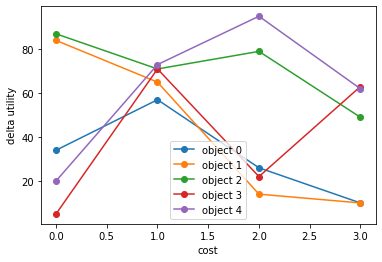

In [6]:
for i, u in enumerate(util_delta):
    plt.plot(u, label=f'object {i}', marker='o')
plt.legend()
plt.xlabel('cost')
plt.ylabel('delta utility')

Text(0, 0.5, 'utility')

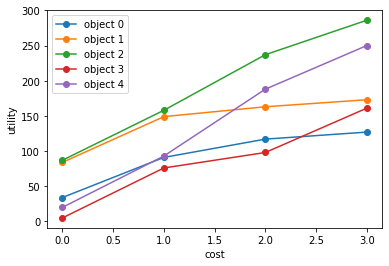

In [7]:
for i, u in enumerate(util):
    plt.plot(u, label=f'object {i}', marker='o')
plt.legend()
plt.xlabel('cost')
plt.ylabel('utility')

In [18]:
#run Z3 solver
solver(util_delta, size, pre_decision, budget)

Solver:


TypeError: float() argument must be a string or a number, not 'IntNumRef'

In [14]:
'''
list all combinations of selecting "budget" items, return the combination with the maximum utility
time complexity increases with greater "budget"

Note that the maximum utility do not neccessary use up all budget, but we can use the leftover budget
'''
[max_utility,selected_layers] = maximize_utility_brute_force(util_delta, size, copy.deepcopy(pre_decision), budget)

print("\nselected layers:")
print(selected_layers)

#output: decision is similar to pre-decision (predecision + new decision)

Brute force:
Time elapsed: 5.99 ms
Max utility: 359
Decision variables (selected layers):
Object 0: [0, 1, 2]
Object 1: [0, 1, 2]
Object 2: []
Object 3: []
Object 4: []

selected layers:
[[1, 1, 1, 0], [1, 1, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]


In [15]:
# multiple choice knapsack solution
# ~40x faster than brute force

def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

num_objects = len(util)
num_layers = len(util[0])

items = list(range(num_objects*num_layers))
values = flatten_concatenation(util)
weights = flatten_concatenation([list(range(i,i+num_layers*i,i)) for i in size])
groups = flatten_concatenation([[i]*num_layers for i in range(num_objects)])

selected_layers_knapsack = solve_multiple_choice_knapsack(items, budget, weights, values, groups)

#print(maxValue)
print(selected_layers_knapsack)

Time elapsed: 0.2 ms
[[1, 1, 1, 0], [1, 1, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]


In [26]:
'''
select 1 item with maximum utiliy at a time from the next feasible layer of each objects. 

For example, if the previous selection:
    Layer 0  1  2  3     feasible layer
Object 0 [1, 0, 0, 0] -> layer 1
Object 1 [0, 0, 0, 0] -> layer 0
Object 2 [1, 1, 0, 0] -> layer 2        -> select one with max. utility 
Object 3 [1, 1, 1, 0] -> layer 3
Object 4 [0, 0, 0, 0] -> layer 0

Ignore the impact of multiple layers selected at a time may yield greater utility
'''
maximize_utility_one_at_a_time(util_delta, size, copy.deepcopy(pre_decision), budget)


NameError: name 'maximize_utility_one_at_a_time' is not defined

In [123]:
#ignore from here on, test
# decision is [0,1, ..., N] layers indicating up to i layers are selected
def solver2(util, size, pre_decision, B, pre_utility, pre_size):
    # Number of objects
    num_objects = len(util)

    # Number of layers per object
    num_layers = len(util[0])

    print("Solver:")
    start = time.time()
    solver = Optimize()

    # Decision variables: 1D array of integer variables
    # decision[i] represents the highest layer of object i selected, or -1 if none are selected
    decision = [Int(f"decision_{i}") for i in range(num_objects)]

    # Add constraints for each decision variable
    for i in range(num_objects):
        # decision_i should be [0, num_layers] inclusive
        solver.add(decision[i] >= 0, decision[i] <= num_layers)

    # Constraint 1: Total size should be <= B
    total_size = Sum([decision[i] * size[i] for i in range(num_objects)])
    solver.add((total_size - pre_size) <= B)

    # Constraint 2: Exclude layers already chosen in previous decision
    for i in range(num_objects):
        solver.add(decision[i] >=  pre_decision[i])


    # Objective: Maximize the sum of utility
    total_utility = IntVal(0)
    for i in range(num_objects):
        for j in range(1, num_layers+1):
            sum_u = Sum(util[i][:j])
            
            total_utility += If(decision[i] == j, sum_u, 0)
    
    max_utility = total_utility - pre_utility
    solver.maximize(max_utility)

    if solver.check() == z3.sat:
        model = solver.model()
        max_utility = model.evaluate(max_utility).as_decimal(5)
        selected_decisions = [model[decision[i]] for i in range(num_objects)]
        print("Time elapsed:", round((time.time() - start) * 1000, 2), "ms")
        print("Max utility:", max_utility)
        print("Decision variables (selected layers):")
        
        updated_decision = copy.deepcopy(pre_decision)
        for i in range(num_objects):
            decision_i = selected_decisions[i].as_long()
            print(f"Object {i}: layer up to {decision_i} selected")
#             if decision_i >= 0:
#                 for j in range(decision_i + 1):
#                     updated_decision[i] = 
#             else:
#                 updated_decision[i] = [0] * num_layers
        
#         print("\nUpdated decision after optimization:")
#         for i in range(num_objects):
#             print("Object", i, updated_decision[i])

    else:
        print("No solution found.")


In [124]:
pre_decision_list = [0, 1, 3, 1, 1]

pre_utility = sum([sum(util_delta[i][:pre_decision_list[i]]) for i in range(len(pre_decision_list))])
pre_size = sum([pre_decision_list[i] * size[i] for i in range(len(pre_decision_list))])
solver2(util_delta, size, pre_decision_list, budget, pre_utility, pre_size)

Solver:
Time elapsed: 70.21 ms
Max utility: 0.3547
Decision variables (selected layers):
Object 0: layer up to 0 selected
Object 1: layer up to 4 selected
Object 2: layer up to 3 selected
Object 3: layer up to 1 selected
Object 4: layer up to 1 selected
